In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

### Note: some code cells repeated across tasks. This is because i was doing the tasks in different times.

### task 1

In [9]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()
df = pd.read_csv('/content/IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['sentiment'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review'].values,
    df['label_encoded'].values,
    test_size=0.2,
    random_state=42
)

In [10]:
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

maxlen = 200
train_padded = pad_sequences(train_sequences, padding='post', maxlen=maxlen)
val_padded = pad_sequences(val_sequences, padding='post', maxlen=maxlen)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

maxlen = 200
train_padded = pad_sequences(train_sequences, padding='post', maxlen=maxlen)
val_padded = pad_sequences(val_sequences, padding='post', maxlen=maxlen)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [ ]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=maxlen),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_rnn = rnn_model.fit(train_padded, train_labels, epochs=5, validation_data=(val_padded, val_labels), batch_size=32)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 57ms/step - accuracy: 0.5059 - loss: 0.6986 - val_accuracy: 0.4993 - val_loss: 0.6953
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.5218 - loss: 0.6907 - val_accuracy: 0.5453 - val_loss: 0.6739
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.5855 - loss: 0.6546 - val_accuracy: 0.5103 - val_loss: 0.6982
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.5972 - loss: 0.6368 - val_accuracy: 0.5017 - val_loss: 0.6922
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.5940 - loss: 0.6368 - val_accuracy: 0.5844 - val_loss: 0.6477


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(maxlen, d_model)

    def get_angles(self, pos, i, d_model):
        angles = pos / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return angles

    def positional_encoding(self, maxlen, d_model):
        angle_rads = self.get_angles(np.arange(maxlen)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

inputs = tf.keras.Input(shape=(maxlen,))
x = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64)(inputs)
x = PositionalEncoding(maxlen, 64)(x)
x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

transformer_model = tf.keras.Model(inputs=inputs, outputs=outputs)

transformer_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_transformer = transformer_model.fit(train_padded, train_labels, epochs=5, validation_data=(val_padded, val_labels), batch_size=32)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 266s 210ms/step - accuracy: 0.7173 - loss: 0.4896 - val_accuracy: 0.8893 - val_loss: 0.2643
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 265s 212ms/step - accuracy: 0.9029 - loss: 0.2415 - val_accuracy: 0.8891 - val_loss: 0.2731
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 257s 206ms/step - accuracy: 0.9233 - loss: 0.1955 - val_accuracy: 0.8785 - val_loss: 0.3201
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 256s 204ms/step - accuracy: 0.9396 - loss: 0.1610 - val_accuracy: 0.8658 - val_loss: 0.3916
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 254s 203ms/step - accuracy: 0.9512 - loss: 0.1335 - val_accuracy: 0.8613 - val_loss: 0.5118


### task 2

In [ ]:
tf.random.set_seed(42)


def scaled_dot_product_attention(q, k, v):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [ ]:
batch_size = 1
num_tokens = 5
depth = 4

q = tf.random.normal(shape=(batch_size, num_tokens, depth))
k = tf.random.normal(shape=(batch_size, num_tokens, depth))
v = tf.random.normal(shape=(batch_size, num_tokens, depth))

output, attention_weights = scaled_dot_product_attention(q, k, v)

print("Attention Weights Shape:", attention_weights.shape)
print("Attention Weights:", attention_weights.numpy())


Attention Weights Shape: (1, 5, 5)
Attention Weights: [[[0.26592588 0.1155308  0.32530454 0.22511546 0.06812333]
  [0.08974529 0.10131478 0.32110986 0.4707869  0.01704323]
  [0.07560908 0.09760934 0.20834142 0.07758293 0.54085726]
  [0.09428679 0.03389525 0.26409352 0.57461256 0.0331119 ]
  [0.15190992 0.01323773 0.144211   0.68251425 0.00812705]]]


2025-05-02 17:56:43.470271: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


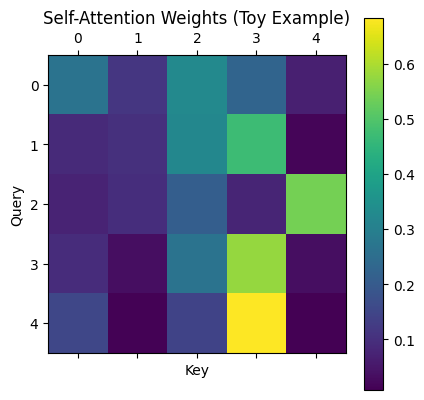

In [ ]:
plt.matshow(attention_weights[0].numpy(), cmap='viridis')
plt.colorbar()
plt.title('Self-Attention Weights (Toy Example)')
plt.xlabel('Key')
plt.ylabel('Query')
plt.show()

### task 3

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Embedding, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

df = pd.read_csv('/content/IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['sentiment'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review'].values,
    df['label_encoded'].values,
    test_size=0.2,
    random_state=42
)

vocab_size = 10000
maxlen = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

train_padded = pad_sequences(train_sequences, padding='post', maxlen=maxlen)
val_padded = pad_sequences(val_sequences, padding='post', maxlen=maxlen)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)


In [ ]:
class PositionalEncoding(Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        self.pos_encoding = self._positional_encoding(maxlen, d_model)

    def _get_angles(self, pos, i, d_model):
        angles = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return angles

    def _positional_encoding(self, maxlen, d_model):
        angle_rads = self._get_angles(
            np.arange(maxlen)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]


In [ ]:
def scaled_dot_product_attention(q, k, v):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_logits = matmul_qk / tf.math.sqrt(dk)
    attention_weights = tf.nn.softmax(scaled_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output

class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        scaled_attention = scaled_dot_product_attention(q, k, v)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.num_heads * self.depth))

        return self.dense(concat_attention)


In [ ]:
class EncoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, *, training=False):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:
class TransformerClassifier(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, num_classes):
        super().__init__()
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff) for _ in range(num_layers)]

        self.dropout = Dropout(0.1)
        self.global_avg_pool = GlobalAveragePooling1D()
        self.fc_out = Dense(num_classes, activation='sigmoid')

    def call(self, x, *, training=False):
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding.output_dim, tf.float32))
        x = self.pos_encoding(x)

        for enc_layer in self.enc_layers:
            x = enc_layer(x, training=training)

        x = self.global_avg_pool(x)
        return self.fc_out(x)


In [ ]:
transformer_classifier = TransformerClassifier(
    num_layers=2,
    d_model=64,
    num_heads=4,
    dff=128,
    input_vocab_size=vocab_size,
    maximum_position_encoding=maxlen,
    num_classes=1
)

transformer_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_custom_transformer = transformer_classifier.fit(
    train_padded, train_labels,
    epochs=3,
    validation_data=(val_padded, val_labels),
    batch_size=32
)


Epoch 1/3


2025-05-02 18:32:53.477776: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_classifier', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 235s 179ms/step - accuracy: 0.7728 - loss: 0.4337 - val_accuracy: 0.8895 - val_loss: 0.2572
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 226s 180ms/step - accuracy: 0.9130 - loss: 0.2236 - val_accuracy: 0.8764 - val_loss: 0.3408
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 224s 180ms/step - accuracy: 0.9411 - loss: 0.1598 - val_accuracy: 0.8703 - val_loss: 0.4393


### task 4

In [2]:
!pip install transformers datasets -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [3]:
!pip install --upgrade transformers


In [11]:
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd

train_df = pd.DataFrame({'text': train_texts[:500], 'label': train_labels[:500]})
val_df = pd.DataFrame({'text': val_texts[:200], 'label': val_labels[:200]})

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], padding="max_length", truncation=True, max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./bert_output',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=50,
    logging_dir='./logs',
    disable_tqdm=True
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mansur17012004 (mansur17012004-kazakh-british-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'loss': 0.5474, 'grad_norm': 6.2626051902771, 'learning_rate': 3.46875e-05, 'epoch': 1.5625}
{'loss': 0.1807, 'grad_norm': 0.5708151459693909, 'learning_rate': 1.90625e-05, 'epoch': 3.125}
{'loss': 0.0307, 'grad_norm': 0.10761696845293045, 'learning_rate': 3.4375000000000005e-06, 'epoch': 4.6875}
{'train_runtime': 70.4912, 'train_samples_per_second': 35.465, 'train_steps_per_second': 2.27, 'train_loss': 0.2396236030384898, 'epoch': 5.0}


TrainOutput(global_step=160, training_loss=0.2396236030384898, metrics={'train_runtime': 70.4912, 'train_samples_per_second': 35.465, 'train_steps_per_second': 2.27, 'train_loss': 0.2396236030384898, 'epoch': 5.0})

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")

prompt = "This movie was so amazing, I couldn't believe"

inputs = gpt_tokenizer.encode(prompt, return_tensors="pt")
gpt_outputs = gpt_model.generate(inputs, max_length=50, num_return_sequences=1, do_sample=True)

generated_text = gpt_tokenizer.decode(gpt_outputs[0], skip_special_tokens=True)
print(generated_text)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


This movie was so amazing, I couldn't believe my eyes!"

"We're going to see a lot of people with that power, and there's a lot more to the film so I feel very lucky."

A spokesman for the


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

sample_review = "summarize: " + df['review'].iloc[0]

inputs = t5_tokenizer.encode(sample_review, return_tensors="pt", max_length=512, truncation=True)

outputs = t5_model.generate(inputs, max_length=50, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)

summary = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Summary:", summary)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Summary: the first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. this show pulls no punches with regards to drugs, sex


### task 5


In [ ]:
!pip install spacy -q
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.9 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install transformers -q


In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

text = """Apple is looking at buying U.K. startup for $1 billion. Elon Musk met with the board in San Francisco."""

doc = nlp(text)

for ent in doc.ents:
    print(f"{ent.text:<20} {ent.label_}")


Apple                ORG
U.K.                 GPE
$1 billion           MONEY
Elon Musk            PERSON
San Francisco        GPE


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

text = """Apple is looking at buying U.K. startup for $1 billion. Elon Musk met with the board in San Francisco."""
ner_results = nlp_ner(text)

for r in ner_results:
    print(f"{r['word']:<20} {r['entity_group']:<10} Score: {r['score']:.2f}")


2025-05-03 16:44:36.990306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746290677.223818      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746290677.291771      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Apple                ORG        Score: 1.00
U. K.                LOC        Score: 1.00
El                   PER        Score: 0.96
##on Musk            PER        Score: 0.91
San Francisco        LOC        Score: 1.00


In [ ]:
for token in doc:
    print(f"{token.text:<15} {token.pos_:<10} {token.tag_}")


Apple           PROPN      NNP
is              AUX        VBZ
looking         VERB       VBG
at              ADP        IN
buying          VERB       VBG
U.K.            PROPN      NNP
startup         NOUN       NN
for             ADP        IN
$               SYM        $
1               NUM        CD
billion         NUM        CD
.               PUNCT      .
Elon            PROPN      NNP
Musk            PROPN      NNP
met             VERB       VBD
with            ADP        IN
the             DET        DT
board           NOUN       NN
in              ADP        IN
San             PROPN      NNP
Francisco       PROPN      NNP
.               PUNCT      .


In [ ]:
!pip install stanza -q
import stanza

stanza.download('en')
nlp_stanza = stanza.Pipeline(lang='en', processors='tokenize,pos')

doc = nlp_stanza("Elon Musk is planning to launch another Tesla model next year.")
for sentence in doc.sentences:
    for word in sentence.words:
        print(f"{word.text:<15} POS: {word.upos}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.3 MB/s eta 0:00:000:00:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is

Elon            POS: PROPN
Musk            POS: PROPN
is              POS: AUX
planning        POS: VERB
to              POS: PART
launch          POS: VERB
another         POS: DET
Tesla           POS: PROPN
model           POS: NOUN
next            POS: ADJ
year            POS: NOUN
.               POS: PUNCT


### task 6

In [ ]:
!pip install datasets seqeval transformers -q


In [ ]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

In [ ]:
from transformers import BertTokenizerFast

label_list = dataset["train"].features["ner_tags"].feature.names
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs



In [ ]:
from datasets import DatasetDict

small_train = dataset["train"].select(range(500))
small_val = dataset["validation"].select(range(100))

tokenized_datasets = DatasetDict({
    "train": small_train.map(tokenize_and_align_labels, batched=True),
    "validation": small_val.map(tokenize_and_align_labels, batched=True)
})


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
from transformers import BertForTokenClassification, TrainingArguments, Trainer
import numpy as np
from seqeval.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))

args = TrainingArguments(
    output_dir="./ner_output",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_preds = [
        [label_list[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    return {
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds),
        "accuracy": accuracy_score(true_labels, true_preds)
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-d580ac98b764>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.664874,0.000000,0.000000,0.000000,0.798519
2,No log,0.388967,0.454545,0.429293,0.441558,0.895556
3,No log,0.312910,0.492228,0.479798,0.485934,0.900741


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=96, training_loss=0.554564913113912, metrics={'train_runtime': 2263.3544, 'train_samples_per_second': 0.663, 'train_steps_per_second': 0.042, 'total_flos': 97992484992000.0, 'train_loss': 0.554564913113912, 'epoch': 3.0})

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
preds = np.argmax(predictions, axis=2)

true_preds = [
    [label_list[p] for (p, l) in zip(pred, label) if l != -100]
    for pred, label in zip(preds, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(pred, label) if l != -100]
    for pred, label in zip(preds, labels)
]

print(classification_report(true_labels, true_preds))


              precision    recall  f1-score   support

         LOC       0.33      0.71      0.45        58
        MISC       0.00      0.00      0.00        12
         ORG       0.50      0.01      0.03        70
         PER       0.80      0.91      0.85        58

   micro avg       0.49      0.48      0.49       198
   macro avg       0.41      0.41      0.33       198
weighted avg       0.51      0.48      0.39       198



### task 7

In [ ]:
!pip install transformers -q


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv("/content/IMDB Dataset.csv")
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review'].values, df['label'].values, test_size=0.2, random_state=42
)

vocab_size = 10000
maxlen = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_seq = tokenizer.texts_to_sequences(train_texts)
val_seq = tokenizer.texts_to_sequences(val_texts)

train_padded = pad_sequences(train_seq, padding='post', maxlen=maxlen)
val_padded = pad_sequences(val_seq, padding='post', maxlen=maxlen)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)


In [ ]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=maxlen),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_lstm = lstm_model.fit(
    train_padded, train_labels,
    epochs=5,
    batch_size=32,
    validation_data=(val_padded, val_labels)
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 165s 130ms/step - accuracy: 0.5888 - loss: 0.6633 - val_accuracy: 0.5439 - val_loss: 0.6846
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 191s 122ms/step - accuracy: 0.6244 - loss: 0.6250 - val_accuracy: 0.8787 - val_loss: 0.2999
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 166s 133ms/step - accuracy: 0.8836 - loss: 0.2848 - val_accuracy: 0.8965 - val_loss: 0.2610
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - accuracy: 0.9230 - loss: 0.2045 - val_accuracy: 0.8958 - val_loss: 0.2768
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 112ms/step - accuracy: 0.9471 - loss: 0.1530 - val_accuracy: 0.8932 - val_loss: 0.3328


In [ ]:
y_pred_lstm = (lstm_model.predict(val_padded) > 0.5).astype(int)

print("LSTM Evaluation:")
print(classification_report(val_labels, y_pred_lstm))
print("Confusion Matrix:")
print(confusion_matrix(val_labels, y_pred_lstm))


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step
LSTM Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4961
           1       0.90      0.89      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
[[4435  526]
 [ 542 4497]]


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

preds = trainer.predict(val_ds)
y_pred = np.argmax(preds.predictions, axis=1)

print("BERT Classification Report:")
print(classification_report(val_df['label'], y_pred))
print("Confusion Matrix:")
print(confusion_matrix(val_df['label'], y_pred))


BERT Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        95
           1       0.85      0.90      0.87       105

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200

Confusion Matrix:
[[78 17]
 [11 94]]


### task 8


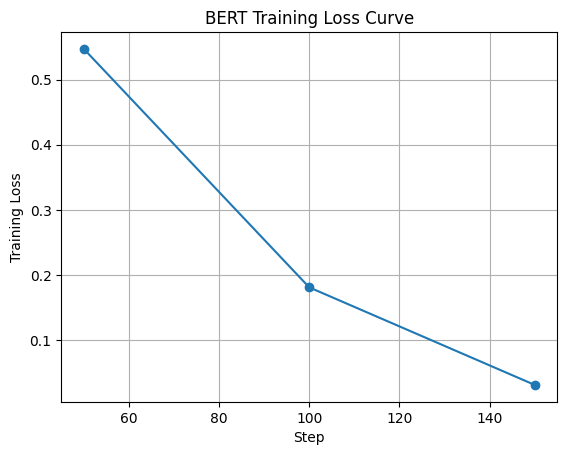

In [13]:
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

steps = [log["step"] for log in training_logs if "loss" in log]
losses = [log["loss"] for log in training_logs if "loss" in log]


plt.plot(steps, losses, marker='o')
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("BERT Training Loss Curve")
plt.grid(True)
plt.show()